<a href="https://colab.research.google.com/github/Chekuriakhilvarma/Project_Code/blob/main/Model_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code to access the files from the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Defining paths for training and testing subsets selected
Train_Images_Sub = '/content/drive/MyDrive/Dataset/train'
Test_Images_Sub = '/content/drive/MyDrive/Dataset/test'

In [3]:
# Install packages needed
!pip install -U keras-cv split-folders
# Import the libraries needed for this dissertation
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# TensorFlow / Keras for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, Input
from tensorflow.keras.models import Model
# InceptionV3 used as the CNN feature extraction branch
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# Used for loading and augmenting the indoor scene image dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Training helpers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Vision Transformer (ViT) model from KerasCV (legacy namespace)
import keras_cv
from keras_cv.src.models.legacy import ViTTiny16
# Metrics for evaluation and confusion matrix generation
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,classification_report)
# Utility for splitting dataset folders into train/val/test sets
import splitfolders
# Reduce TensorFlow log noise and ignore warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 53.8 MB/s eta 0:00:00


In [4]:
# Split the indoor scene dataset into training and validation subsets
splitfolders.ratio(Train_Images_Sub,output="/content/Sub_trn_Split",seed=24000105,
    ratio=(0.70, 0.30),move=False)
# Directories for the resulting training and validation subsets
Sub_trn_Train_Split = "/content/Sub_trn_Split/train"
Sub_trn_Val_Split   = "/content/Sub_trn_Split/val"

Copying files: 3981 files [03:05, 21.41 files/s] 


In [5]:
# Image resolution used for all indoor scene classification models
indoor_image_size = (299, 299)
# Number of images processed per batch during training and validation
indoor_batch_size = 32
# Data augmentation applied to the indoor scene training images
indoor_train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# Generator for indoor scene validation images without augmentation
indoor_val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
# Loads the indoor scene training samples
indoor_train_loader = indoor_train_data_generator.flow_from_directory(
    Sub_trn_Train_Split,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=True)
# Loads the indoor scene validation samples
indoor_val_loader = indoor_val_data_generator.flow_from_directory(
    Sub_trn_Val_Split,
    target_size=indoor_image_size,
    batch_size=indoor_batch_size,
    class_mode='categorical',
    shuffle=False)
# Number of indoor scene categories
num_scene_classes = indoor_train_loader.num_classes
# Names of the indoor scene classes
scene_class_labels = list(indoor_train_loader.class_indices.keys())

Found 2777 images belonging to 15 classes.
Found 1204 images belonging to 15 classes.


In [6]:
# Image resolution and batch size for the Vision Transformer indoor scene model
indoor_vit_image_size = (224, 224)
indoor_vit_batch_size = 32

# Data augmentation for indoor scene training images
indoor_vit_train_data_generator = ImageDataGenerator(
    rescale= 1/ 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data generator with no aug
indoor_vit_val_data_generator = ImageDataGenerator(rescale=1.0 / 255)

# Test data generator
indoor_vit_test_data_generator = ImageDataGenerator(rescale=1.0 / 255)

# Training loader for indoor scene images
indoor_vit_train_loader = indoor_vit_train_data_generator.flow_from_directory(
    Sub_trn_Train_Split,
    target_size=indoor_vit_image_size,
    batch_size=indoor_vit_batch_size,
    class_mode="sparse",
    shuffle=True
)

# Validation loader for indoor scene images
indoor_vit_val_loader = indoor_vit_val_data_generator.flow_from_directory(
    Sub_trn_Val_Split,
    target_size=indoor_vit_image_size,
    batch_size=indoor_vit_batch_size,
    class_mode="sparse",
    shuffle=False
)

# Test loader for indoor scene images
indoor_vit_test_loader = indoor_vit_test_data_generator.flow_from_directory(
    Test_Images_Sub,
    target_size=indoor_vit_image_size,
    batch_size=indoor_vit_batch_size,
    class_mode="sparse",
    shuffle=False
)

# Number of indoor scene categories
indoor_vit_num_scene_classes = indoor_vit_train_loader.num_classes

# Category labels for indoor scene dataset
indoor_vit_scene_class_labels = list(indoor_vit_train_loader.class_indices.keys())

print("Classes:", indoor_vit_scene_class_labels)


Found 2777 images belonging to 15 classes.
Found 1204 images belonging to 15 classes.
Found 766 images belonging to 15 classes.
Classes: ['bakery', 'casino', 'dining_room', 'elevator', 'garage', 'hospitalroom', 'jewelleryshop', 'kitchen', 'livingroom', 'movietheater', 'pantry', 'prisoncell', 'stairscase', 'toystore', 'warehouse']


In [7]:
# Build a Vision Transformer model for indoor scene classification
def build_indoor_vit_tiny16_classifier(
    input_shape=indoor_vit_image_size + (3,),
    num_classes=indoor_vit_num_scene_classes,
    dropout_rate=0.3,
):
    # Input layer for ViT-based indoor scene classifier
    vit_input_tensor = keras.Input(shape=input_shape)

    # ViT-Tiny16 backbone of ImageNet-pretrained
    indoor_vit_backbone = ViTTiny16(
        include_rescaling=False,
        include_top=False,
        weights="imagenet",
        input_tensor=vit_input_tensor,
        pooling="token_pooling",
        activation=tf.keras.activations.gelu,
        name="Indoor_ViT_Tiny16_Backbone",
    )

    # Enable fine-tuning of the full ViT backbone
    indoor_vit_backbone.trainable = True

    # Classification head for indoor scene recognition
    vit_features = indoor_vit_backbone.output
    vit_features = layers.Dropout(dropout_rate)(vit_features)
    vit_features = layers.Dense(256, activation="relu")(vit_features)
    vit_features = layers.Dropout(dropout_rate)(vit_features)
    vit_scene_predictions = layers.Dense(num_classes, activation="softmax")(vit_features)

    # Complete ViT-Tiny indoor scene classification model
    indoor_vit_model = keras.Model(
        inputs=vit_input_tensor,
        outputs=vit_scene_predictions,
        name="Indoor_ViT_Tiny16_Classifier"
    )

    return indoor_vit_model

# Create and summarise the ViT-Tiny16 indoor scene model
indoor_vit_tiny16_model = build_indoor_vit_tiny16_classifier()
indoor_vit_tiny16_model.summary(line_length=150)


22349232/22349232 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Indoor_ViT_Tiny16_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                                     ┃ Output Shape                                  
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                                         │ (None, 224, 224, 3)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ rescaling_2 (Rescaling)                                          │ (None, 224, 224, 3)                           
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ patching_and_embedding (PatchingAndEmbedding)                    │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ dropout (Dropout)                                                │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder (TransformerEncoder)                         │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_1 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_2 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_3 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_4 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_5 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_6 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_7 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_8 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_9 (TransformerEncoder)                       │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_10 (TransformerEncoder)                      │ (None, 197, 192)                              
├──────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────
│ transformer_encoder_11 (TransformerEncoder)                      │ (None, 197, 192)                              
├───────────────────────────────────────────────────────

 Total params: 5,577,679 (21.28 MB)

 Trainable params: 5,577,679 (21.28 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Number of epochs for training the ViT-Tiny16 indoor scene model
indoor_vit_epochs = 25

# Compile the ViT-Tiny16 indoor scene classifier
indoor_vit_tiny16_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping for ViT-Tiny16 training
indoor_vit_early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Checkpoint to store the best-performing ViT-Tiny16 indoor scene model
indoor_vit_checkpoint = callbacks.ModelCheckpoint(
    "best_indoor_vit_tiny16_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the ViT-Tiny16 indoor scene classification model
indoor_vit_training_history = indoor_vit_tiny16_model.fit(
    indoor_vit_train_loader,
    validation_data=indoor_vit_val_loader,
    epochs=indoor_vit_epochs,
    callbacks=[indoor_vit_early_stop, indoor_vit_checkpoint],
    verbose=1
)


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.2446 - loss: 3.7595
Epoch 1: val_accuracy improved from -inf to 0.70930, saving model to best_indoor_vit_tiny16_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 120s 793ms/step - accuracy: 0.2460 - loss: 3.7454 - val_accuracy: 0.7093 - val_loss: 1.0261
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6368 - loss: 1.2845
Epoch 2: val_accuracy improved from 0.70930 to 0.75914, saving model to best_indoor_vit_tiny16_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.6371 - loss: 1.2834 - val_accuracy: 0.7591 - val_loss: 0.8416
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7276 - loss: 0.9289
Epoch 3: val_accuracy improved from 0.75914 to 0.82060, saving model to best_indoor_vit_tiny16_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.7278 - loss: 0.9283 - val_accuracy: 0.8206 - val_loss: 0.5725
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7779 - loss: 0.7122
Epoch 4: val_accuracy improved from 0.82060 to 0.86130, saving model to best_indoor_vit_tiny16_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.7778 - loss: 0.7125 - val_accuracy: 0.8613 - val_loss: 0.4825
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8318 - loss: 0.5401
Epoch 5: val_accuracy improved from 0.86130 to 0.88040, saving model to best_indoor_vit_tiny16_model.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.8317 - loss: 0.5403 - val_accuracy: 0.8804 - val_loss: 0.3974
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8634 - loss: 0.4423
Epoch 6: val_accuracy did not improve from 0.88040
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 475ms/step - accuracy: 0.8633 - loss: 0.4427 - val_accuracy: 0.8804 - val_loss: 0.4457
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8691 - loss: 0.3860
Epoch 7: val_accuracy did not improve from 0.88040
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.8690 - loss: 0.3863 - val_accuracy: 0.8721 - val_loss: 0.4724
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8833 - loss: 0.3566
Epoch 8: val_accuracy did not improve from 0.88040
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 469ms/step - accuracy: 0.8832 - loss: 0.3569 - val_accuracy: 0.8630 - val_loss: 0.5730
Epoch 9/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9132 - loss: 0.2819
Epoch 9: val_accuracy did not i

87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 482ms/step - accuracy: 0.9184 - loss: 0.2823 - val_accuracy: 0.8821 - val_loss: 0.5124


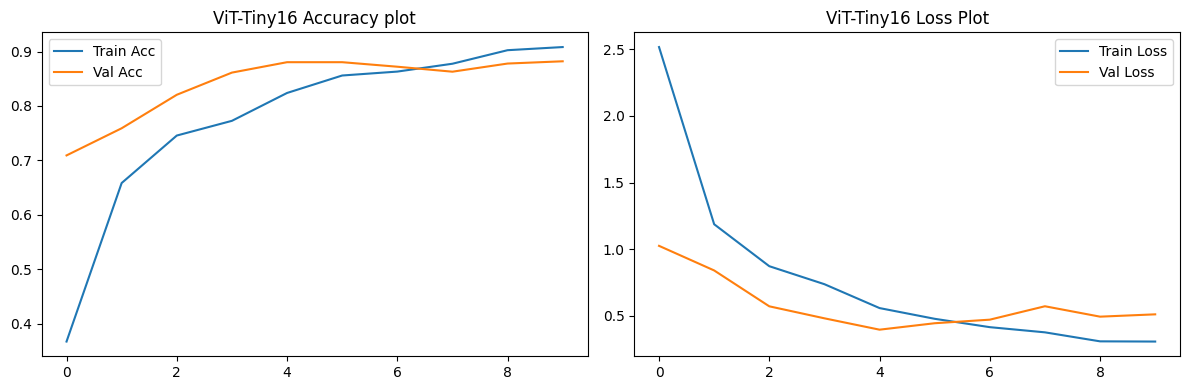

In [9]:
# Plot learning curves for the ViT-Tiny16 indoor scene model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(indoor_vit_training_history.history["accuracy"], label="Train Acc")
plt.plot(indoor_vit_training_history.history["val_accuracy"], label="Val Acc")
plt.title("ViT-Tiny16 Accuracy plot")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(indoor_vit_training_history.history["loss"], label="Train Loss")
plt.plot(indoor_vit_training_history.history["val_loss"], label="Val Loss")
plt.title("ViT-Tiny16 Loss Plot")
plt.legend()

plt.tight_layout()
plt.show()



In [10]:
# Evaluate the ViT-Tiny16 model on the indoor scene validation set
indoor_vit_val_loss, indoor_vit_val_accuracy = indoor_vit_tiny16_model.evaluate(
    indoor_vit_val_loader,
    verbose=1
)

print(f"Validation accuracy for ViT-Tiny16: {indoor_vit_val_accuracy:.4f}")
print(f"Validation loss for ViT-Tiny16: {indoor_vit_val_loss:.4f}")



38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8789 - loss: 0.4027
Validation accuracy for ViT-Tiny16: 0.8804
Validation loss for ViT-Tiny16: 0.3974


38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step


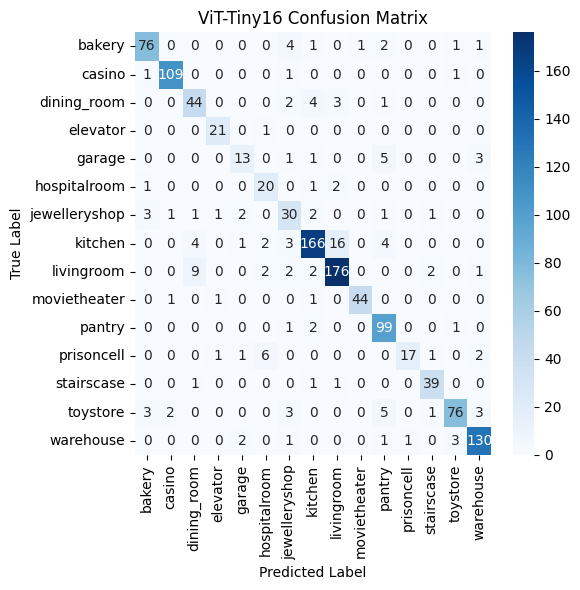

In [11]:
# Generate predictions for the validation set
indoor_vit_val_loader.reset()
indoor_vit_val_probabilities = indoor_vit_tiny16_model.predict(
    indoor_vit_val_loader,
    verbose=1
)

# Convert probabilities to predicted class indices
indoor_vit_val_predicted_labels = np.argmax(indoor_vit_val_probabilities, axis=1)

# True labels from the validation dataset
indoor_vit_val_true_labels = indoor_vit_val_loader.classes

# Compute confusion matrix for validation performance
indoor_vit_val_confusion_mat = confusion_matrix(
    indoor_vit_val_true_labels,
    indoor_vit_val_predicted_labels
)

# Code to display the confusion matrix along with labels and axis titles
plt.figure(figsize=(6, 6))
sns.heatmap(
    indoor_vit_val_confusion_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=indoor_vit_scene_class_labels,
    yticklabels=indoor_vit_scene_class_labels
)
plt.title("ViT-Tiny16 Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



In [12]:
# Classification report for the validation set
print("\nViT-Tiny16 Classification Report")
print(
    classification_report(
        indoor_vit_val_true_labels,
        indoor_vit_val_predicted_labels,
        target_names=indoor_vit_scene_class_labels
    )
)



ViT-Tiny16 Classification Report
               precision    recall  f1-score   support

       bakery       0.90      0.88      0.89        86
       casino       0.96      0.97      0.97       112
  dining_room       0.75      0.81      0.78        54
     elevator       0.88      0.95      0.91        22
       garage       0.68      0.57      0.62        23
 hospitalroom       0.65      0.83      0.73        24
jewelleryshop       0.62      0.71      0.67        42
      kitchen       0.92      0.85      0.88       196
   livingroom       0.89      0.91      0.90       194
 movietheater       0.98      0.94      0.96        47
       pantry       0.84      0.96      0.90       103
   prisoncell       0.94      0.61      0.74        28
   stairscase       0.89      0.93      0.91        42
     toystore       0.93      0.82      0.87        93
    warehouse       0.93      0.94      0.94       138

     accuracy                           0.88      1204
    macro avg       0.85     

24/24 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - accuracy: 0.8462 - loss: 0.4864
Test accuracy (ViT-Tiny16): 0.8394
Test loss (ViT-Tiny16): 0.5019
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step


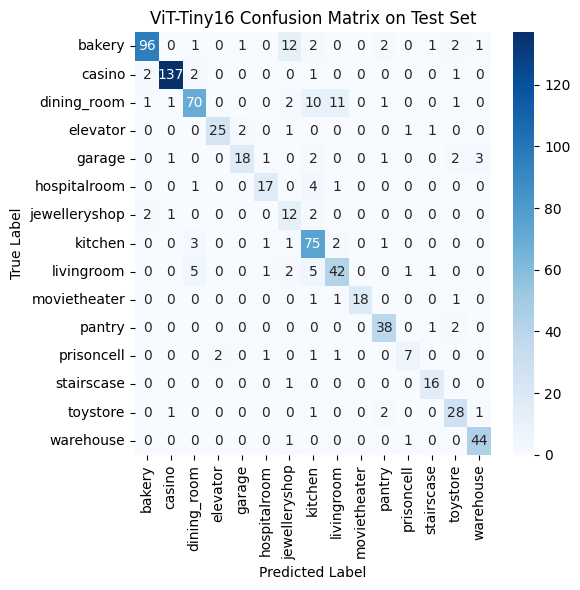


ViT-Tiny16 Classification Report on Test Set
               precision    recall  f1-score   support

       bakery       0.95      0.81      0.88       118
       casino       0.97      0.96      0.96       143
  dining_room       0.85      0.72      0.78        97
     elevator       0.93      0.83      0.88        30
       garage       0.86      0.64      0.73        28
 hospitalroom       0.81      0.74      0.77        23
jewelleryshop       0.38      0.71      0.49        17
      kitchen       0.72      0.90      0.80        83
   livingroom       0.72      0.74      0.73        57
 movietheater       1.00      0.86      0.92        21
       pantry       0.84      0.93      0.88        41
   prisoncell       0.70      0.58      0.64        12
   stairscase       0.80      0.94      0.86        17
     toystore       0.76      0.85      0.80        33
    warehouse       0.90      0.96      0.93        46

     accuracy                           0.84       766
    macro avg    

In [14]:
#Load best ViT model and evaluate on TEST set
best_indoor_vit_tiny16_model = indoor_vit_tiny16_model


# Evaluate on test data
indoor_vit_test_loss, indoor_vit_test_accuracy = best_indoor_vit_tiny16_model.evaluate(
    indoor_vit_test_loader,
    verbose=1
)

print(f"Test accuracy (ViT-Tiny16): {indoor_vit_test_accuracy:.4f}")
print(f"Test loss (ViT-Tiny16): {indoor_vit_test_loss:.4f}")

# Predictions, confusion matrix and classification report

# Reset generator and get predictions
indoor_vit_test_loader.reset()
indoor_vit_test_probabilities = best_indoor_vit_tiny16_model.predict(
    indoor_vit_test_loader,
    verbose=1
)

# Predicted labels
indoor_vit_test_predicted_labels = np.argmax(indoor_vit_test_probabilities, axis=1)

# True labels
indoor_vit_test_true_labels = indoor_vit_test_loader.classes

# Confusion matrix
indoor_vit_test_confusion_mat = confusion_matrix(
    indoor_vit_test_true_labels,
    indoor_vit_test_predicted_labels
)

plt.figure(figsize=(6, 6))
sns.heatmap(
    indoor_vit_test_confusion_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=indoor_vit_scene_class_labels,
    yticklabels=indoor_vit_scene_class_labels
)
plt.title("ViT-Tiny16 Confusion Matrix on Test Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Classification report
print("\nViT-Tiny16 Classification Report on Test Set")
print(
    classification_report(
        indoor_vit_test_true_labels,
        indoor_vit_test_predicted_labels,
        target_names=indoor_vit_scene_class_labels
    )
)


In [15]:
# --- Grad-CAM-style saliency for ViT ---

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import os

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load an image from disk and preprocess for the ViT model (rescale to [0,1])."""
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return img, np.expand_dims(img_array, axis=0)


def make_gradcam_heatmap_vit(img_array, model, class_index=None):
    """
    Compute a Grad-CAM-style heatmap for ViT by using gradients of the class score
    w.r.t. the input image pixels, then aggregating across channels.

    img_array: np.array of shape (1, H, W, 3) in [0,1]
    model: trained Keras model (your ViT classifier)
    class_index: int or None. If None, uses the model's top predicted class.
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        class_channel = preds[:, class_index]

    # Gradient of class score w.r.t. input image
    grads = tape.gradient(class_channel, img_tensor)

    # Aggregate along channels: take mean of absolute gradients
    grads = tf.abs(grads)
    grads = tf.reduce_mean(grads, axis=-1)[0]

    # Normalize to [0,1]
    heatmap = tf.maximum(grads, 0)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-8)

    return heatmap.numpy(), int(class_index.numpy())


def overlay_heatmap_on_image(original_pil_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlay a heatmap onto the original image.

    original_pil_img: PIL image (unscaled, RGB)
    heatmap: 2D numpy array in [0,1]
    """
    # Convert PIL to OpenCV format (BGR)
    img = np.array(original_pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    heatmap_color = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized),
        colormap
    )

    # Overlay heatmap on image
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    # Convert back to RGB for matplotlib
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img_rgb, overlay


Test image path: /content/drive/MyDrive/Dataset/test/bakery/Bakery_Photos_jpg.rf.9338227e3fcdb0303eee44cd0610addc.jpg
Predicted class: bakery


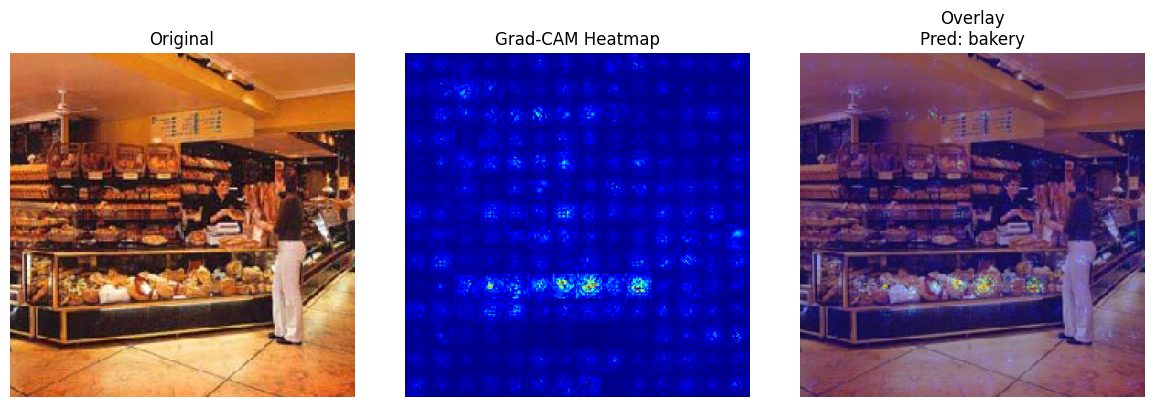

In [16]:
# Make sure we are using the best model
vit_model_for_cam = best_indoor_vit_tiny16_model

# use the first image in the test generator
test_index = 0
test_image_path = indoor_vit_test_loader.filepaths[test_index]
print("Test image path:", test_image_path)

# Load and preprocess
orig_img, img_array = load_and_preprocess_image(
    test_image_path,
    target_size=indoor_vit_image_size  # (224,224)
)

# Get heatmap and class index
heatmap, class_index = make_gradcam_heatmap_vit(
    img_array,
    vit_model_for_cam,
    class_index=None
)

predicted_class_name = indoor_vit_scene_class_labels[class_index]
print("Predicted class:", predicted_class_name)

# Overlay heatmap
img_rgb, overlay = overlay_heatmap_on_image(orig_img, heatmap, alpha=0.4)

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Overlay\nPred: {predicted_class_name}")

plt.tight_layout()
plt.show()


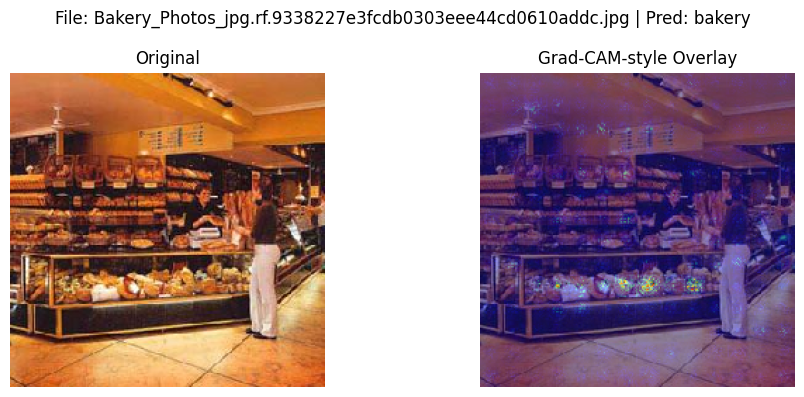

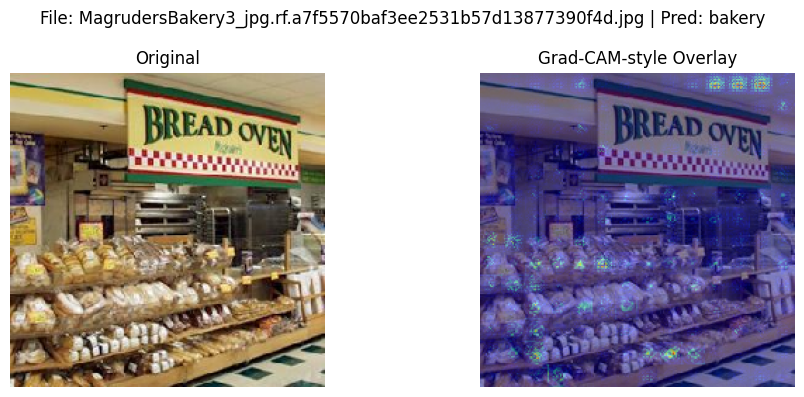

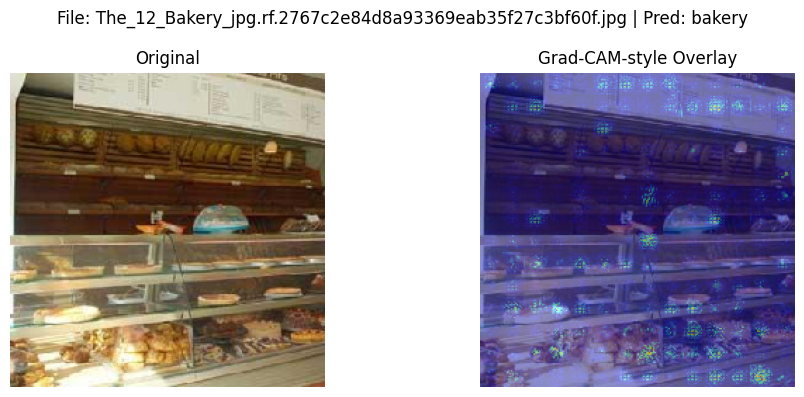

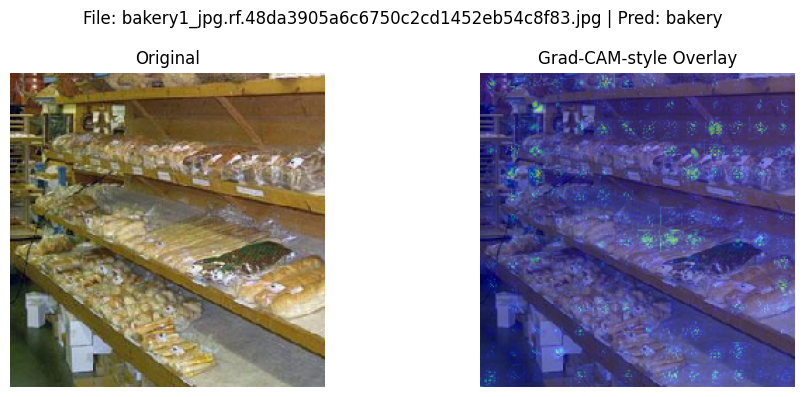

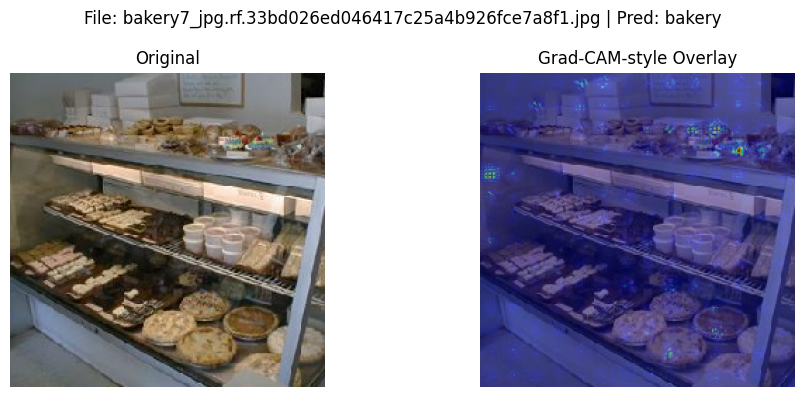

In [17]:
# Visualise Grad-CAM-style maps for the first N test images
N = 5

for idx in range(N):
    img_path = indoor_vit_test_loader.filepaths[idx]
    orig_img, img_array = load_and_preprocess_image(
        img_path,
        target_size=indoor_vit_image_size
    )

    heatmap, class_index = make_gradcam_heatmap_vit(
        img_array,
        vit_model_for_cam,
        class_index=None
    )
    predicted_class_name = indoor_vit_scene_class_labels[class_index]

    img_rgb, overlay = overlay_heatmap_on_image(orig_img, heatmap, alpha=0.45)

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"File: {os.path.basename(img_path)} | Pred: {predicted_class_name}", fontsize=12)

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM-style Overlay")

    plt.tight_layout()
    plt.show()
